In [49]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.metrics import confusion_matrix
import random
from sklearn.model_selection import train_test_split
np.random.seed(0)

In [7]:
(X_train, y_train), (X_test, y_test) = imdb.load_data()

In [13]:
indexes = imdb.get_word_index(path="imdb_word_index.json")

1641221/1641221 [==============================] - 1s 0us/step


In [8]:
print('x_train:\t{}' .format(X_train.shape))
print('y_train:\t{}' .format(y_train.shape))
print('x_test:\t\t{}'.format(X_test.shape))
print('y_test:\t\t{}'.format(y_test.shape))

x_train:	(25000,)
y_train:	(25000,)
x_test:		(25000,)
y_test:		(25000,)


In [20]:
len(X_train[6])

123

In [69]:
# Use the default parameters to keras.datasets.imdb.load_data
start_char = 1
oov_char = 2
index_from = 3
# Retrieve the training sequences.
(x_train, _), _ = imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from
)
# Retrieve the word index file mapping words to indices
word_index = imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words
# And add `index_from` to indices to sync with `x_train`
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = ""
inverted_word_index[oov_char] = "[OOV]"
# Decode the first sequence in the dataset
decoded_sequences= []
for sequence in x_train:
    decoded_sequences.append(" ".join(inverted_word_index[i] for i in sequence))

decoded_sequences= pd.Series(decoded_sequences)

In [70]:
random_elem = random.choices(decoded_sequences, k=10)

In [71]:
random_elem

[" gena rowlands plays an actress who loses her grip on reality when she witnesses the death of a fan of hers she becomes increasingly deluded from reality and as a result her emotional turmoil intrudes with her work as an actress in the sense that she breaks all the rules of acting and improvises everything yet still manages to engage her audience makes the film interesting if a bit self important as a parallel of cassavettes' own struggles as a filmmaker there's so many ideas thrown around and as result it becomes a bit muddled i'm still pondering the relation between the dead fan and rowlands among many other things but the way they're presented in their rawest form makes it a consistently interesting and thought provoking film would be great on a double bill with mulholland drive br br",
 " the latest rumor going around is that vh1 is starting casting calls for i love new york 3 mid 2008 so does this mean budah or tailor made dumped new york or does this mean new york dumped the wi

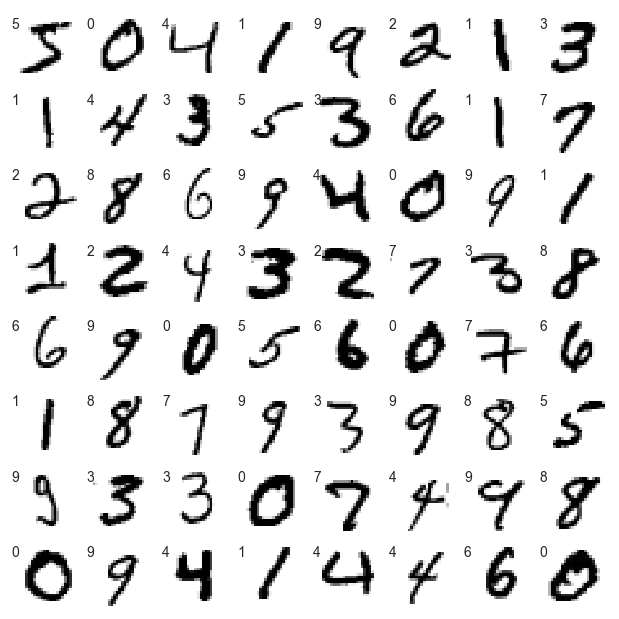

In [5]:
# set up the figure
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 28x28 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(y_train[i]))


In [6]:
img_rows, img_cols = 28, 28

X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255.
X_test /= 255.

print('X_train:\t{}' .format(X_train.shape),' -reshaped')
print('X_test: \t{}' .format(X_test.shape),' -reshaped')

X_train:	(60000, 28, 28, 1)  -reshaped
X_test: 	(10000, 28, 28, 1)  -reshaped


In [7]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

In [8]:
pd.DataFrame(y_train)

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...
59995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
59996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
59997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
59998,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [9]:
# Hyperparameters
training_epochs = 10 # Total number of training epochs
learning_rate = 0.001 # The learning rate

In [10]:
# create a model
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 32)         128       
 ormalization)                                                   
                                                        

In [11]:
results = model.fit(
    X_train, y_train,
    epochs= training_epochs,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 2
)

Epoch 1/10
1875/1875 - 19s - loss: 0.0922 - accuracy: 0.9712 - val_loss: 0.0747 - val_accuracy: 0.9772 - 19s/epoch - 10ms/step
Epoch 2/10



KeyboardInterrupt



In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
prediction_values = model.predict(X_test, max_queue_size=1)

In [ ]:
print(prediction_values[2])

In [ ]:
print("Evaluating on training set...")
(loss, accuracy) = model.evaluate(X_train,y_train, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))


print("Evaluating on testing set...")
(loss, accuracy) = model.evaluate(X_test, y_test, verbose=0)
print("loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

In [ ]:
# summarize history for accuracy
plt.subplot(211)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])

# summarize history for loss
plt.subplot(212)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.tight_layout()

max_loss = np.max(results.history['loss'])
min_loss = np.min(results.history['loss'])
print("Maximum Loss : {:.4f}".format(max_loss))
print("Minimum Loss : {:.4f}".format(min_loss))
print("Loss difference : {:.4f}".format((max_loss - min_loss)))

По графиками видно что оптимальное количество епох 2, дальше растёт количество потерь и падает accuracy. Пересоздаём модель с меньшшим количеством эпох.

In [ ]:
# Hyperparameters
training_epochs = 2 # Total number of training epochs
learning_rate = 0.001 # The learning rate

In [ ]:
# create a model
def create_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model()
model.summary()

In [ ]:
results = model.fit(
    X_train, y_train,
    epochs= training_epochs,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 2
)

In [ ]:
model.evaluate(X_test,y_test)

In [ ]:
prediction_values = model.predict(X_test, max_queue_size=1)

In [ ]:
Y_true = np.argmax(y_test,axis = 1)
pred_values = np.argmax(prediction_values,axis = 1)
confusion_mtx = confusion_matrix(Y_true, pred_values)
sns.heatmap(confusion_mtx, annot=True, fmt="d")
plt.ylabel('True')
plt.xlabel('Predicted')